In [1]:
import urllib.request
import os
import tarfile
import pickle as p
import numpy as np

url = 'https://www.cs.to onto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'F:/DLdata/traindata/cifar-10-python.tar.gz'

if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
else:
    print('Data file already exist.')

if not os.path.exists("F:/DLdata/traindata/cifar-10-batches-py"):
    tfile = tarfile.open("F:/DLdata/traindata/cifar-10-python.tar.gz",'r:gz')
    result = tfile.extractall('F:/DLdata/traindata/')
    print('Extracted to F:/DLdata/traindata/cifar-10-batches-py/')
else:
    print('Directory already exist.')

Data file already exist.
Directory already exist.


In [2]:
#批次处理图像数据
def load_CIFAR_batch(filename):
    """load single batch of cifar"""
    with open(filename,'rb')as f:  # rb(read binary)是读取二进制文件。
        
        #一个样本由标签和图像数据组成
        #<1*label><3027*pixel>(3072=32*32*3)
        # ...
        #<1*label><3027*pixel>
        
        data_dict = p.load(f,encoding='bytes')#反序列化对象，将文件中的数据解析为一个python对象。
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        #把原始数据结构调整为BCWH
        images = images.reshape(10000,3,32,32)
        #tensorflow处理图像的数据结构：BWHC
        #把通道数据C移动到最后一个维度
        images = images.transpose(0,2,3,1)
        
        labels = np.array(labels) #将其转换为一维数组
        return images, labels

In [3]:
#完整读取数据
def load_CIFAR_data(data_dir):
    """load CIFAR data"""
    
    images_train=[]
    labels_train=[]
    for i in range(5):
        f = os.path.join(data_dir,'data_batch_%d' % (i+1)) #连接两个的路径名组件,拼接地址
        print('loading',f)
        #调用load_CIFAR_batch()获取批量的图像及其对应的标签
        image_batch,labels_batch=load_CIFAR_batch(f)
        images_train.append(image_batch) #添加到列表末尾的对象
        labels_train.append(labels_batch)
        Xtrain = np.concatenate(images_train) #进行数组的拼接
        Ytrain = np.concatenate(labels_train)
        del image_batch,labels_batch #删除两个变量
        
    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finish loadding CIFAR-10 data')
        
    #返回训练集的图像和标签，测试集的图像和标签
    return Xtrain,Ytrain,Xtest,Ytest
    
data_dir = 'F:/DLdata/traindata/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest = load_CIFAR_data(data_dir)

loading F:/DLdata/traindata/cifar-10-batches-py/data_batch_1
loading F:/DLdata/traindata/cifar-10-batches-py/data_batch_2
loading F:/DLdata/traindata/cifar-10-batches-py/data_batch_3
loading F:/DLdata/traindata/cifar-10-batches-py/data_batch_4
loading F:/DLdata/traindata/cifar-10-batches-py/data_batch_5
finish loadding CIFAR-10 data


In [4]:
print('training data shape:',Xtrain.shape)
print('training labels shape:',Ytrain.shape)
print('test data shape:',Xtest.shape)
print('test label shape:',Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test label shape: (10000,)


2


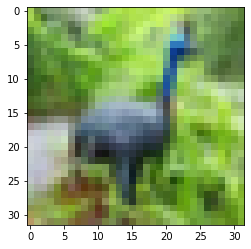

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(Xtrain[6])
print(Ytrain[6])

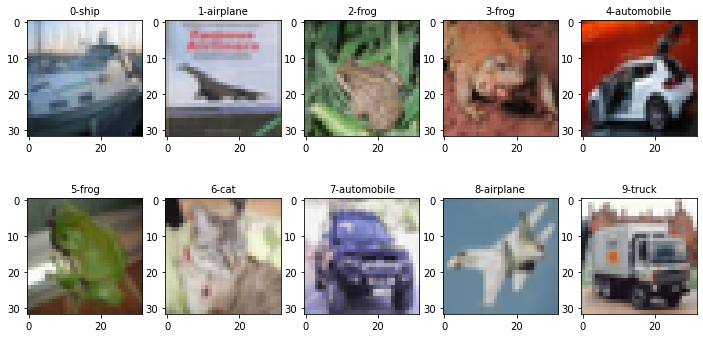

In [6]:
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

#定义显示图像数据及其对应标签的函数

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6) #整张图长12英寸，高6英寸
    if num>10:
        num = 10
    for i in range(0,num):
        ax = plt.subplot(2,5,1+i) #分成2*5张图，第1+i个位置
        ax.imshow(images[idx],cmap='binary')
        
        title  = str(i)+'-'+label_dict[labels[idx]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[idx]]
        
        ax.set_title(title,fontsize=10)
        
        idx+=1
    plt.show()
    
#显示图像数据及其对应标签
plot_images_labels_prediction(Xtest,Ytest,[],2,10)

In [7]:
#查看图像数据信息
#显示第二个图的第一个像素点
Xtrain[1][0][0] #第2张图的第一个像素点

array([154, 177, 187], dtype=uint8)

In [8]:
#将图像进行数字标准化,归一化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

In [9]:
Xtrain_normalize[1][0][0]

array([0.6039216 , 0.69411767, 0.73333335], dtype=float32)

In [10]:
#查看标签数据
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)

In [12]:
Ytrain_onehot.shape

(50000, 10)

In [13]:
Ytrain[:5]

array([6, 9, 9, 4, 1])

In [14]:
Ytrain_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


In [16]:
                ###定义共享函数###

#定义权值    
def weight(shape):
    #在构建模型时，需要使用tf.Variable来创建一个变量
    #在训练时，这个变量不断更新
    #使用函数tf.truncated_normal(截断的正态分布)生成标准差为0.1的随机数来初始化权值
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')


#定义偏置
#初始化为1
def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')

#定义卷积操作
#步长为1，padding为'SAME'
def conv2d(x,W):
    #tf.nn.conv2d(input,filter,strides,padding,use_cudnn_on_gpu=True,name=None)
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

#定义池化操作
#步长为2，即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    #tf.nn.max_pool(x,ksize,strides,padding, name=None)
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [17]:
                ###定义网络结构###

#输入层
#32*32图像，通道为3(RGB)
with tf.name_scope('input_layer'):
    x = tf.placeholder('float',shape=[None,32,32,3],name="x")
    
#第一个卷积层
#输入通道数：3，输出通道数32，卷积后图像尺寸不变
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32])  #[k_width,k_height,input_chn,output_chn]
    b1 = bias([32]) #与output_chn一致
    conv_1 = conv2d(x,W1) + b1
    conv_1 = tf.nn.relu(conv_1)
    
#第一个池化层
#将32*32图像缩小为16*16，池化层不改变通道
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)
    
#第二个卷积层
#输入通道数：32，输出通道数64，卷积后图像尺寸不变
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])  #[k_width,k_height,input_chn,output_chn]
    b2 = bias([64]) #与output_chn一致
    conv_2 = conv2d(pool_1,W2) + b2
    conv_2 = tf.nn.relu(conv_2)

#第二个池化层
#将16*16图像缩小为8*8，池化层不改变通道
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)

#全连接层
#将池第2个池化层的64个8*8的图像转换为一维的向量，长度是64*8*8=4096
#128个神经元
with tf.name_scope('fc'):
    W3 = weight([4096,128]) #有128个神经元
    b3 = bias([128])
    flat = tf.reshape(pool_2,[-1,4096])
    h = tf.nn.relu(tf.matmul(flat,W3) + b3)
    h_dropout = tf.nn.dropout(h,keep_prob=0.8)
    
#输出层
#输出层共有10个神经元，对应0-9这10个类别
with tf.name_scope('output_layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout,W4)+b4)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
                ###构建模型###
    
with tf.name_scope("optimizer"):
    #定义占位符
    y = tf.placeholder("float",shape=[None,10],name="label")
    
    #定义损失函数
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    
    #选择优化器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
                ###定义准确率###
with tf.name_scope("evalution"):
    correct_prediction = tf.equal(tf.arg_max(pred,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

In [20]:
                ###启动会话###
    
from time import time

train_epochs = 25
batch_size = 50
total_batch = int(len(Xtrain)/batch_size)
epoch_list = []
accuracy_list = []
loss_list = []

epoch = tf.Variable(0,name='epoch',trainable=False)

startTime = time()

sess = tf.Session()
init =tf.global_variables_initializer()
sess.run(init)

In [21]:
                ###断点续训###
#设置检查存储目录
ckpt_dir = "F:\DLdata\ckpt_dir/"

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

#生成saver
saver = tf.train.Saver(max_to_keep=1)

#如果有检查点的文件，读取最新的检查点的文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess,ckpt) #加载所有的参数
    #从这里开始就可以直接使用模型进行预测，或者接着继续训练了
else:
    print("Training from scratch.")
    
#获取续训参数
start = sess.run(epoch)
print("Training starts from {} epoch.".format(start+1))

Training from scratch.
Training starts from 1 epoch.


In [22]:
                ###迭代训练###
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number*batch_size:(number + 1)*batch_size],Ytrain_onehot[number*batch_size:(number + 1)*batch_size]

for ep in range(start, train_epochs):
    
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x:batch_x, y:batch_y})
        if i % 100 ==0:
            print("Step {}".format(i), "finished")
    
    loss,acc = sess.run([loss_function,accuracy],feed_dict={x:batch_x, y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss);
    accuracy_list.append(acc)
    
    print("Train epoch:", '%02d' % (sess.run(epoch)+1),"Loss=","{:.6f}".format(loss)," Accuracy=" ,acc)

    #保存检查点
    saver.save(sess,ckpt_dir + "CIFAR10_cnn_model.cpkt",global_step=ep+1)
    sess.run(epoch.assign(ep + 1))
    
    duration =time() - startTime
    print("Train finished takes:",duration)

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 01 Loss= 2.163130  Accuracy= 0.3
Train finished takes: 4.873993158340454
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 02 Loss= 2.105906  Accuracy= 0.38
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Train finished takes: 7.721378803253174
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
Train epoch: 03 Loss= 2.114088  Accuracy= 0.36
Train finished takes: 10.588711261749268
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finish

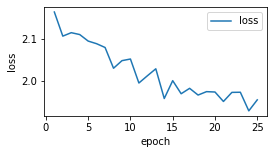

In [23]:
                ###可视化损失值###
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc = 'upper right')

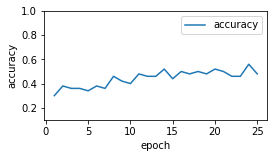

In [24]:
                ###可视化准确率###
plt.plot(epoch_list,accuracy_list,label="accuracy")
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [25]:
                ###计算测试集上的准确率###
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+ 1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict = {x:test_image_batch, y:test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.614900


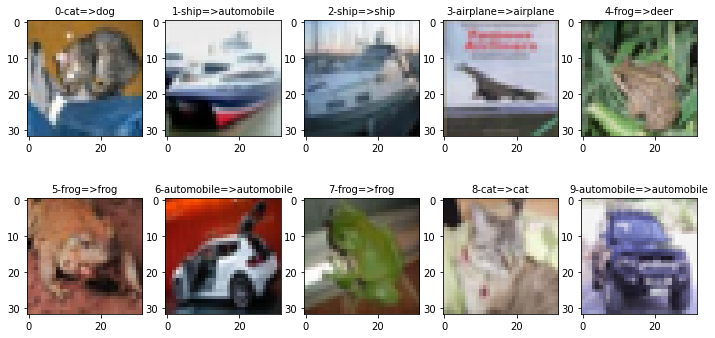

In [26]:
#利用模型进行预测
test_pred = sess.run(pred, feed_dict={x:Xtest_normalize[:10]})
prediction_result = sess.run(tf.arg_max(test_pred,1))

#可视化预测结果
plot_images_labels_prediction(Xtest,Ytest,prediction_result,0,10)